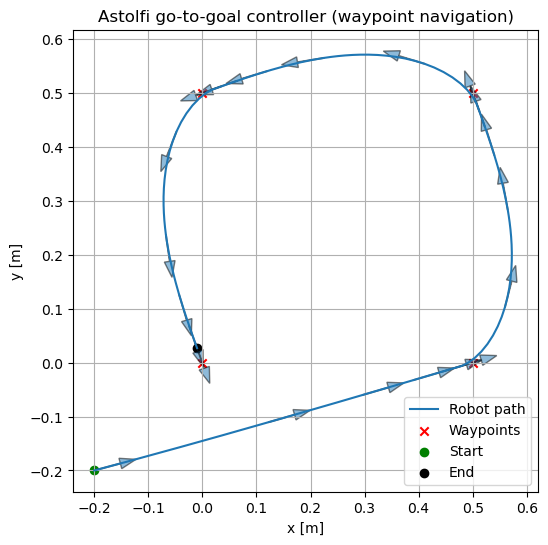

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helpers ----------

def wrap_to_pi(angle):
    """Wrap angle to (-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

# ---------- Controller ----------

def astolfi_goto_waypoint(x, y, theta, x_w, y_w, k_rho=0.8, k_alpha=2.0):
    """
    Astolfi-style go-to-goal controller (no orientation objective).
    Returns (v, omega).
    """
    dx = x_w - x
    dy = y_w - y

    rho = np.hypot(dx, dy)
    alpha = wrap_to_pi(np.arctan2(dy, dx) - theta)

    # Linear velocity
    v = k_rho * rho * np.cos(alpha)

    # Angular velocity
    omega = k_alpha * alpha

    return v, omega, rho, alpha

# ---------- Simulation ----------

def simulate_unicycle_path(
    waypoints,
    x0=0.0, y0=0.0, theta0=0.0,
    k_rho=0.8, k_alpha=2.0,
    dt=0.05,
    max_time=60.0,
    waypoint_tol=0.05,
    allow_backward=True,
):
    """
    Simulate the Thymio following a list of waypoints with the Astolfi go-to-goal controller.
    Returns arrays of x, y, theta, and the index at which the simulation stopped.
    """
    x, y, theta = x0, y0, theta0

    xs = [x]
    ys = [y]
    thetas = [theta]
    waypoint_indices = [0]

    t = 0.0
    current_idx = 0
    n_wp = len(waypoints)

    while t < max_time and current_idx < n_wp:
        x_w, y_w = waypoints[current_idx]

        v, omega, rho, alpha = astolfi_goto_waypoint(
            x, y, theta, x_w, y_w,
            k_rho=k_rho, k_alpha=k_alpha)

        # Check if waypoint reached
        if rho < waypoint_tol:
            current_idx += 1
            # Store index for plotting
            waypoint_indices.append(min(current_idx, n_wp - 1))
            continue

        # Unicycle dynamics (Euler integration)
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta = wrap_to_pi(theta + omega * dt)

        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        waypoint_indices.append(current_idx)

        t += dt

    return np.array(xs), np.array(ys), np.array(thetas), waypoint_indices

# ---------- Run an example ----------

if __name__ == "__main__":
    # Define waypoints (you can change these)
    waypoints = [
        (0.5, 0.0),
        (0.5, 0.5),
        (0.0, 0.5),
        (0.0, 0.0)
    ]

    # Initial pose (try weird orientations like theta0 = np.pi)
    x0, y0, theta0 = -0.2, -0.2, np.deg2rad(15)

    xs, ys, thetas, wp_idx = simulate_unicycle_path(
        waypoints,
        x0=x0, y0=y0, theta0=theta0,
        k_rho=1,
        k_alpha=3,
        dt=0.05,
        max_time=60.0,
        waypoint_tol=0.03)

    # ---------- Plot ----------
    plt.figure(figsize=(6, 6))
    plt.plot(xs, ys, label="Robot path")
    
    # Plot waypoints
    wpx = [w[0] for w in waypoints]
    wpy = [w[1] for w in waypoints]
    plt.scatter(wpx, wpy, c="red", marker="x", label="Waypoints")

    # Mark start and end
    plt.scatter([xs[0]], [ys[0]], c="green", label="Start")
    plt.scatter([xs[-1]], [ys[-1]], c="black", label="End")

    # Optionally draw heading arrows at a few points
    step = max(1, len(xs) // 20)
    for i in range(0, len(xs), step):
        plt.arrow(xs[i], ys[i],
                  0.05*np.cos(thetas[i]),
                  0.05*np.sin(thetas[i]),
                  head_width=0.02, alpha=0.5)

    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Astolfi go-to-goal controller (waypoint navigation)")
    plt.show()


In [4]:
print("test")

test
